## Mound Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cat /content/drive/My\ Drive/Colab\ Notebooks/FacialExpression/Project1/Project-1/foo.txt

**Size  96x96**

In [ ]:
import pickle

root_path = '/content/drive/My Drive/Colab Notebooks/Maleria/'


**Size 64x64**

In [ ]:
import pickle

root_path = '/content/drive/My Drive/Colab Notebooks/Maleria/'


In [ ]:
EMOTIONS = ["Parasitized", "Uninfected"] # two class

In [ ]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import Dense
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import pickle


In [ ]:
# parameters
batch_size = 64
num_epochs =50
depth = 3
INIT_LR = 1e-3 # for linear and poly initial LR used 1e-1
verbose = 1
num_classes = 2 # classes 8 for CK+; Fer 2013 is 7
patience = 5


In [ ]:
from tensorflow.keras.applications import VGG19

In [ ]:
# Load VGG19 model with pre-trained weights
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(64, 64 ,3))

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
# Load VGG19 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96 ,3))

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
from keras.applications import InceptionV3

In [ ]:
# For inception network minimum input size is 75 by 75

baseModel = InceptionV3(weights=None, include_top=False,
	input_tensor=Input(shape=(H, W, depth)))  # if we want to add specific models weight use in option weights = "imagenet"

In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(Classes, activation="softmax")(headModel)
#headModel = Dense(len(config.CLASSES), activation="softmax")(headModel)

In [ ]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = True  # if not need to train use False

In [ ]:
model.summary()

In [ ]:
from keras.applications import InceptionResNetV2

In [ ]:
# MINIMUM HIGHT AND WEIGHT IS 75
#base_model = InceptionResNetV2(include_top=True, weights=None, input_tensor=None, input_shape=None, pooling=None, classes=7)
base_model = InceptionResNetV2(include_top=True, weights=None, input_tensor=None, input_shape=(H, W, depth), pooling=None, classes=Classes)

In [ ]:
model = base_model

In [ ]:
model.summary()

In [ ]:
def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same", # 32
			input_shape = inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		#model.add(Conv2D(32, (3, 3), padding="same"))
		#model.add(Activation("relu"))
		#model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.10))

		# second CONV => RELU => CONV => RELU => POOL layer set
		#model.add(Conv2D(64, (3, 3), padding="same")) # 64
		#model.add(Activation("relu"))
		#model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.20))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		#model.add(Dense(1024))
		#model.add(Activation("relu"))
		#model.add(BatchNormalization())
		#model.add(Dropout(0.4))
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.3))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [ ]:
H = W = 64
model = build(width = H, height = W, depth = depth, classes = Classes)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1

In [ ]:
from keras.optimizers import SGD
from keras.optimizers import Adam
#from keras_radam import RAdam

INIT_LR = 1e-3 # 1e-3
num_epochs = 50
opt = Adam(learning_rate=INIT_LR)

print("[INFO] compiling model...")
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

[INFO] compiling model...


In [ ]:
H = model_call = model.fit(trainX, trainY, batch_size,
                        epochs=num_epochs, verbose=1,
                        validation_data=(testX, testY))

Epoch 1/50
431/431 [==============================] - 24s 22ms/step - loss: 0.5399 - accuracy: 0.7570 - val_loss: 0.7341 - val_accuracy: 0.7522
Epoch 2/50
431/431 [==============================] - 9s 20ms/step - loss: 0.2011 - accuracy: 0.9262 - val_loss: 0.3597 - val_accuracy: 0.8540
Epoch 3/50
431/431 [==============================] - 9s 20ms/step - loss: 0.1451 - accuracy: 0.9495 - val_loss: 0.1502 - val_accuracy: 0.9485
Epoch 4/50
431/431 [==============================] - 9s 20ms/step - loss: 0.1290 - accuracy: 0.9546 - val_loss: 0.1419 - val_accuracy: 0.9609
Epoch 5/50
431/431 [==============================] - 9s 21ms/step - loss: 0.1154 - accuracy: 0.9587 - val_loss: 0.0991 - val_accuracy: 0.9720
Epoch 6/50
431/431 [==============================] - 8s 19ms/step - loss: 0.1059 - accuracy: 0.9613 - val_loss: 1.2213 - val_accuracy: 0.6555
Epoch 7/50
431/431 [==============================] - 9s 21ms/step - loss: 0.1097 - accuracy: 0.9613 - val_loss: 0.1739 - val_accuracy: 0.943

[INFO] Showing Model Trainning and Testing Accuracy...


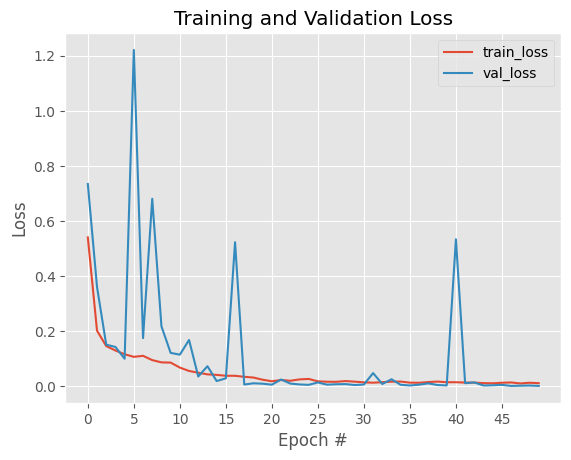

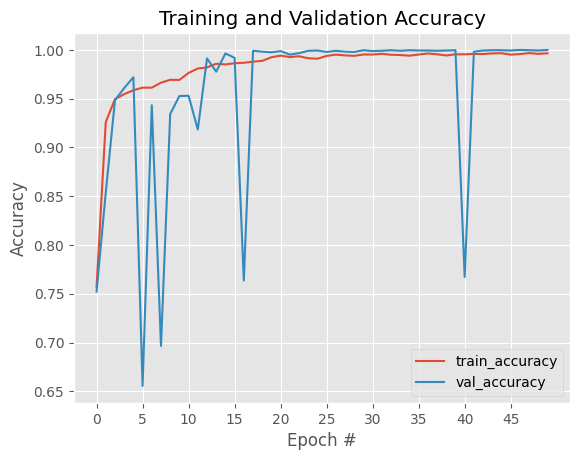

In [ ]:
#base_path = '/content/drive/My Drive/Colab Notebooks/FacialExpression/Project1/Project-1/modelsCK+FaceLast3/12-10-19/'

#model_name = '_OWN_v2_C7Face3_28_9_19_'
#trained_models_path = base_path + model_name


#H = model_call
import matplotlib.pyplot as plt
# save the multi-label binarizer to disk
print("[INFO] Showing Model Trainning and Testing Accuracy...")
#f = open(args["labelbin"], "wb")
#f = open("mlb.pickle", "wb")
#f.write(pickle.dumps(mlb))
#f.close()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = num_epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.xticks(np.arange(0, N, step=5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right") #upper left

#plt.savefig(base_path+"plot-LOSSCK+-12-10")
#plt.savefig("plot-LOSSCK+-12-10")

plt.figure()
plt.plot(np.arange(0, N, step=1), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N, step=1), H.history["val_accuracy"], label="val_accuracy")
plt.xticks(np.arange(0, N, step=5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right") # upper

#plt.savefig(base_path+"plot-ACCURACYCK+-12-10")
#plt.savefig("plot-ACCURACY-12-10")

In [ ]:
from sklearn.metrics import classification_report
# make predictions on the test set
preds = model.predict(testX)
report = classification_report(testY.argmax(axis=1), preds.argmax(axis=1),
	target_names=EMOTIONS)
# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(classification_report(testY.argmax(axis=1), preds.argmax(axis=1),
	target_names=EMOTIONS))

104/104 [==============================] - 1s 4ms/step
[INFO] evaluating network...
              precision    recall  f1-score   support

 Parasitized       1.00      1.00      1.00      1656
  Uninfected       1.00      1.00      1.00      1665

    accuracy                           1.00      3321
   macro avg       1.00      1.00      1.00      3321
weighted avg       1.00      1.00      1.00      3321



In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, precision_score,recall_score, f1_score,roc_auc_score

testY_F = testY.argmax(axis=1)
prediction_F = preds.argmax(axis=1)

print(confusion_matrix(testY_F, prediction_F))
print ('Accuracy Score::',accuracy_score(testY_F, prediction_F))


print ('precision Score::',precision_score(testY_F, prediction_F, average = 'macro'))
print ('Recall Score::',recall_score(testY_F, prediction_F, average = 'macro'))
print ('F1 Score::',f1_score(testY_F, prediction_F, average = 'macro'))
print ('ROC and AUC Score: ', roc_auc_score(testY, preds)) # ROC and AUC score nees the probability

[[1656    0]
 [   0 1665]]
Accuracy Score:: 1.0
precision Score:: 1.0
Recall Score:: 1.0
F1 Score:: 1.0
ROC and AUC Score:  1.0


In [ ]:
def plot_confusion_matrix(cm,
                  target_names,
                  title='Confusion matrix',
                  cmap=None,
                  normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap) # bicubic
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #bottom, top = plt.get_ylim()
    #plt.set_ylim(bottom + 0.5, top - 0.5)
    plt.grid(False)
    plt.show()

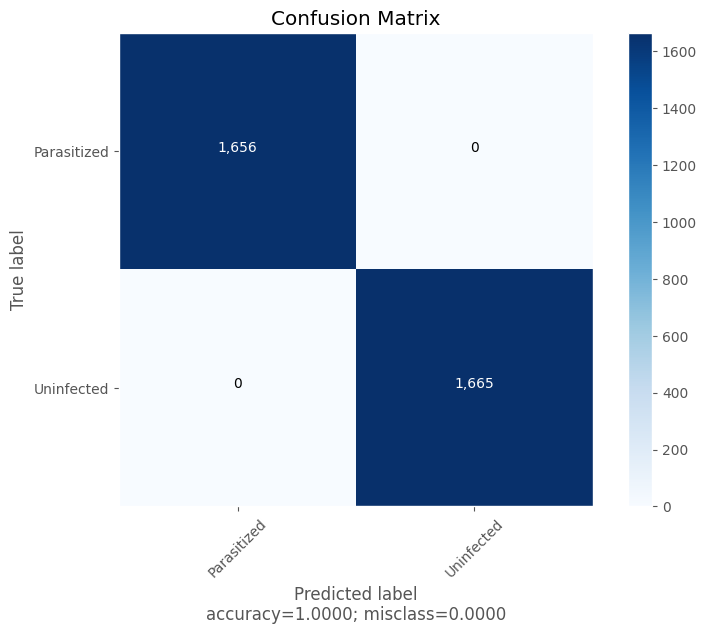

In [ ]:
cm = confusion_matrix(testY_F, prediction_F)
plot_confusion_matrix(cm           = np.array(cm),
                      normalize    = False,
                      target_names = EMOTIONS,
                      title        = "Confusion Matrix")

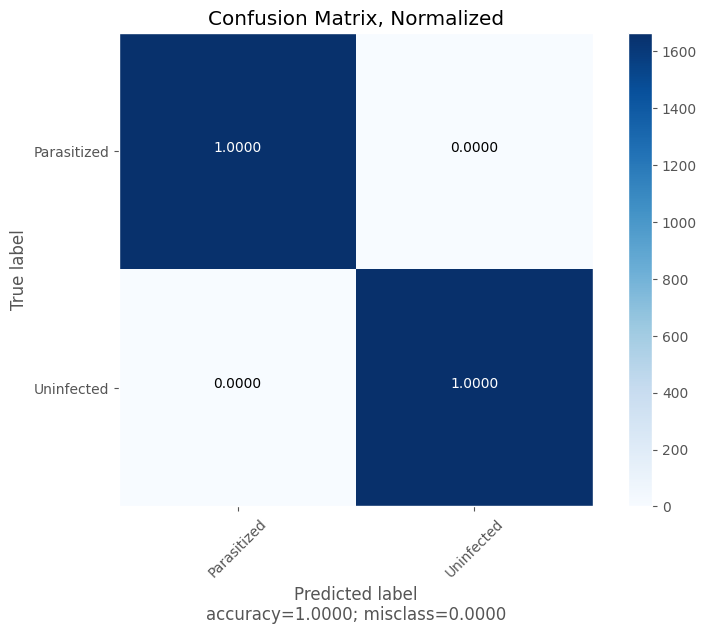

In [ ]:
plot_confusion_matrix(cm           = np.array(cm),
                      normalize    = True,
                      target_names = EMOTIONS,
                      title        = "Confusion Matrix, Normalized")

In [ ]:
from sklearn.metrics import roc_auc_score, auc, roc_curve
preds_roc = model.predict(testX)

104/104 [==============================] - 0s 4ms/step


**For Test**

In [ ]:
print ('ROC and AUC Score: ', roc_auc_score(testY, preds_roc)) # ROC and AUC score nees the probability
FPR, TPR, Threshold = roc_curve(testY.ravel(), preds_roc.ravel())
roc_result = auc(FPR, TPR)

ROC and AUC Score:  1.0


**Show the Curve**

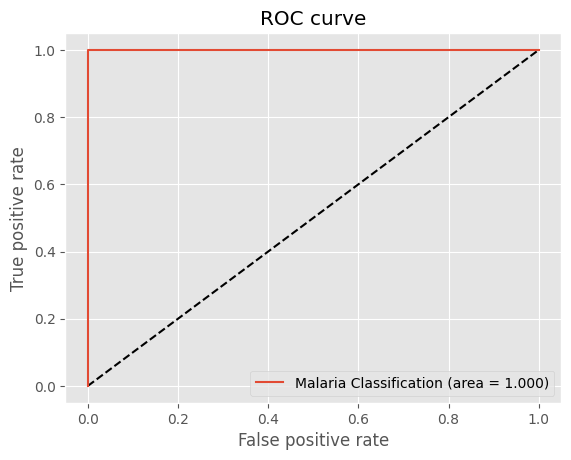

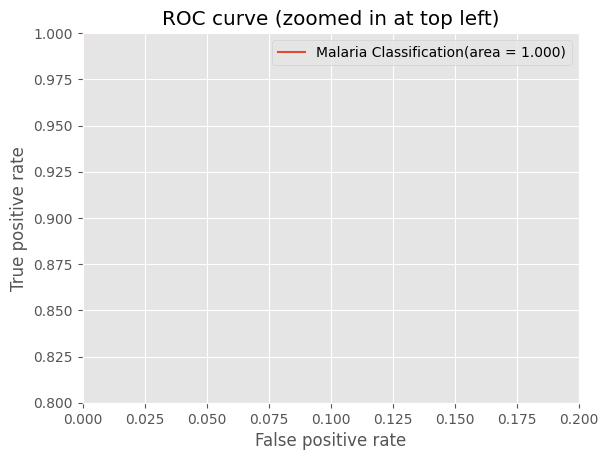

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(FPR, TPR, label='Malaria Classification (area = {:.3f})'.format(roc_result))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(FPR, TPR, label='Malaria Classification(area = {:.3f})'.format(roc_result))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()